![MLU Logo](../../data/MLU_Logo.png)

# <a name="0">Machine Learning Accelerator - Natural Language Processing - Lecture 3</a>

## Neural Networks with PyTorch

In this notebook, we will build, train and validate a Neural Network using PyTorch.
1. <a href="#1">Implementing a neural network with PyTorch</a>
2. <a href="#2">Loss Functions</a>
3. <a href="#3">Training</a>
4. <a href="#4">Example - Binary Classification</a>
5. <a href="#5">Natural Language Processing Context</a>

In [1]:
! pip install -q -r ../../requirements.txt

## 1. <a name="1">Implementing a neural network with PyTorch</a>
(<a href="#0">Go to top</a>)

Let's implement a simple neural network with two hidden layers of size 64 and 128 using the sequential mode (Adding things in sequence). We will have 3 inputs, 2 hidden layers and 1 output layer. Some drop-outs attached to the hidden layers.

In [2]:
import torch
from torch import nn

net = nn.Sequential(
        nn.Linear(in_features=3,       # Input size of 3 is expected
                  out_features=64),    # Linear layer-1 with 64 units
        nn.Tanh(),                     # Tanh activation is applied
        nn.Dropout(p=.4),              # Apply random 40% drop-out to layer_1
        nn.Linear(64, 64),             # Linear layer-2 with 64 units  
        nn.Tanh(),                     # Tanh activation is applied
        nn.Dropout(p=.3),              # Apply random 30% drop-out to layer_2
        nn.Linear(64,1))               # Output layer with single unit

print(net)

Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)


We can initialize the weights of the network with 'initialize()' function. We prefer to use the following:

In [3]:
def xavier_init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

net.apply(xavier_init_weights)

Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)

Let's look at our layers and dropouts on them. We can easily access them wth net[layer_index]

In [4]:
print(net[0])
print(net[1])
print(net[2])
print(net[3])
print(net[4])

Linear(in_features=3, out_features=64, bias=True)
Tanh()
Dropout(p=0.4, inplace=False)
Linear(in_features=64, out_features=64, bias=True)
Tanh()


## 2. <a name="2">Loss Functions</a>
(<a href="#0">Go to top</a>)

We can select [loss functions](https://d2l.ai/chapter_linear-networks/linear-regression.html#loss-function) according to our problem. A full list of supported `Loss` functions in PyTorch are available [here](https://pytorch.org/docs/stable/nn.html#loss-functions). 

Let's go over some popular loss functions and see how to call a built-in loss function:


__Binary Cross-entropy Loss:__ A common used loss function for binary classification. 

```python
loss = nn.BCELoss()
```

__Categorical Cross-entropy Loss:__ A common used loss function for multi-class classification. 

```python
loss = nn.CrossEntropyLoss()
```

__MSE Loss:__ One of the most common loss functions for regression problems. 

```python
loss = nn.MSELoss()
```

__L1 Loss:__ This is similar to L2 loss. It measures the abolsute difference between target values (y) and predictions (p).
$$
\mathrm{L1 loss} = \frac{1}{2} \sum_{examples}|y - p|
$$
In pytorch, we can use it with `L1Loss`:
```python
loss = nn.L1Loss()
```

## 3. <a name="3">Training</a>
(<a href="#0">Go to top</a>)

`torch.optim` module provides necessary optimization algorithms for neural networks. We can use the following `Optimizers` to train a network using [Stochastic Gradient Descent (SGD)](https://d2l.ai/chapter_optimization/sgd.html) method and learning rate of 0.001.

```python
from torch import optim
optimizer = optim.SGD(net.parameters(), lr=0.001)
```

## 4. <a name="4">Example - Binary Classification</a>
(<a href="#0">Go to top</a>)

Let's train a neural network on a random dataset. We have two classes and will learn to classify them.

In [5]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=750, shuffle=True, random_state=42, noise=0.05, factor=0.3)

Let's plot the dataset

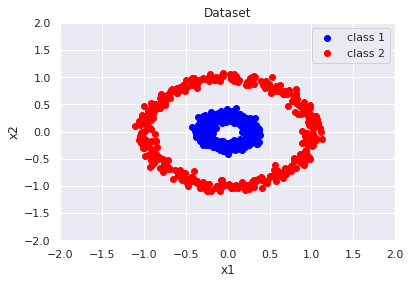

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dataset(X, y, title):
    
    # Activate Seaborn visualization
    sns.set()
    
    # Plot both classes: Class1->Blue, Class2->Red
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', label="class 1")
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', label="class 2")
    plt.legend(loc='upper right')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.title(title)
    plt.show()
    
plot_dataset(X, y, title="Dataset")

Importing the necessary libraries

In [7]:
import time
from torch.nn import BCELoss

We are creating the network below. We will have two hidden layers. Since the data seems easily seperable, we can have a small network (2 hidden layers) with 10 units at each layer.

In [8]:
net = nn.Sequential(nn.Linear(in_features=2, out_features=10),
                    nn.ReLU(),
                    nn.Linear(10, 10),
                    nn.ReLU(),
                    nn.Linear(10, 1),
                    nn.Sigmoid())

Let's define the training parameters

In [9]:
batch_size = 4           # How many samples to use for each weight update 
epochs = 50              # Total number of iterations
learning_rate = 0.01     # Learning rate
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs = 50   # Total number of iterations
lr = 0.01     # Learning rate

# Define the loss. As we used sigmoid in the last layer, we use `nn.BCELoss`.
# Otherwise we could have made use of `nn.BCEWithLogitsLoss`.
loss = BCELoss(reduction='none')

# Define the optimizer, SGD with learning rate
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [10]:
# Split the dataset into two parts: 80%-20% split
X_train, X_val = X[0:int(len(X)*0.8), :], X[int(len(X)*0.8):, :]
y_train, y_val = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

# Use PyTorch DataLoaders to load the data in batches
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                               torch.tensor(y_train, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

# Move validation dataset on CPU/GPU device
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

Let's start the training process. We will have training and validation sets and print our losses at each step.

In [11]:
train_losses = []
val_losses = []
for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    # Build a training loop, to train the network
    for idx, (data, target) in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        data = data.to(device)
        target = target.to(device).view(-1, 1)
        
        output = net(data)
        L = loss(output, target).sum()
        training_loss += L.item()
        L.backward()
        optimizer.step()
    
    # Get validation predictions
    val_predictions = net(X_val)
    # Calculate the validation loss
    val_loss = torch.sum(loss(val_predictions, y_val.view(-1, 1))).item()
    
    # Take the average losses
    training_loss = training_loss / len(y_train)
    val_loss = val_loss / len(y_val)
    
    train_losses.append(training_loss)
    val_losses.append(val_loss)
    
    end = time.time()
    print("Epoch %s. Train_loss %f Validation_loss %f Seconds %f" % \
          (epoch, training_loss, val_loss, end-start))

Epoch 0. Train_loss 0.683368 Validation_loss 0.672652 Seconds 0.114386
Epoch 1. Train_loss 0.659161 Validation_loss 0.640252 Seconds 0.110025
Epoch 2. Train_loss 0.612653 Validation_loss 0.576983 Seconds 0.110307
Epoch 3. Train_loss 0.519522 Validation_loss 0.453729 Seconds 0.109495
Epoch 4. Train_loss 0.355015 Validation_loss 0.256830 Seconds 0.109672
Epoch 5. Train_loss 0.173642 Validation_loss 0.112044 Seconds 0.109459
Epoch 6. Train_loss 0.078574 Validation_loss 0.057430 Seconds 0.109570
Epoch 7. Train_loss 0.043240 Validation_loss 0.035353 Seconds 0.109722
Epoch 8. Train_loss 0.027795 Validation_loss 0.024446 Seconds 0.109792
Epoch 9. Train_loss 0.019697 Validation_loss 0.018246 Seconds 0.109409
Epoch 10. Train_loss 0.014902 Validation_loss 0.014356 Seconds 0.109793
Epoch 11. Train_loss 0.011810 Validation_loss 0.011703 Seconds 0.109629
Epoch 12. Train_loss 0.009648 Validation_loss 0.009832 Seconds 0.109857
Epoch 13. Train_loss 0.008097 Validation_loss 0.008443 Seconds 0.109754
Ep

Let's see the training and validation loss plots below. Losses go down as the training process continues as expected.

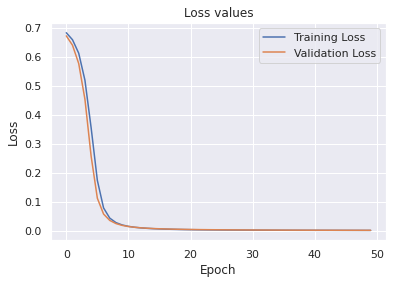

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 5. <a name="5">Natural Language Processing Context</a>
(<a href="#0">Go to top</a>)

If we want to use the same type of architecture for text classification, we need to apply some feature extraction methods first. For example: We can get TF-IDF vectors of text fields. After that, we can use neural networks on those features. 

We will also look at __more advanced neural network architrectures__ such as __Recurrent Neural Networks (RNNs)__, __Long Short-Term Memory networks (LSTMs)__ and __Transformers__. 